# Projekt: Fehlererkennung in Getrieben

#### **Importieren der Bibliotheken**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from pathlib import Path
from modules.data_handler import Dataset, fetch_kaggle_dataset
import yaml
import seaborn as sns

#### **Laden der Datensätze**

In [2]:
# fetch_kaggle_dataset("jishnukoliyadan/vibration-analysis-on-rotating-shaft")

In [3]:
# # load data from folder and split in training and evaluation data

# data_path = Path().cwd() / "data"

# training_data = []
# evaluation_data = []

# print("READING TRAINING DATA")
# for file_path in data_path.glob("*D.csv"):
#     training_data.append(Dataset(file_path))
#     print(f"{file_path.name} completed!")

# print("READING EVALUATION DATA")
# for file_path in data_path.glob("*E.csv"):
#     evaluation_data.append(Dataset(file_path))
#     print(f"{file_path.name} completed!")

#### **Kontrolle der Daten**

In [4]:
test = Dataset(Path("./data/3D.csv"))

print(test)

,unbalance,mass,mass_tolerance,radius,radius_tolerance,voltage_start,voltage_end,voltage_step
0,significant,3.281,0.003,23.0,0.1,2.0,10.05,0.05


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.638791e+07,2.638790e+07,2.638791e+07,2.638791e+07,2.638790e+07
mean,5.996809e+00,-3.577469e+04,1.110836e-03,2.465983e-03,3.448805e-03
std,2.326625e+00,2.989907e+06,4.001031e-02,7.958974e-02,3.795273e-02
min,0.000000e+00,-2.400000e+08,-1.187980e-01,-1.914287e-01,-3.666401e-02
25%,4.000000e+00,1.051479e+03,-1.876354e-03,-2.229214e-03,1.395941e-03
50%,6.000000e+00,1.479773e+03,6.973743e-04,6.723404e-04,2.921820e-03
75%,8.000000e+00,1.906608e+03,3.694296e-03,3.556013e-03,4.649162e-03
max,1.000000e+01,4.091723e+03,6.956823e+00,8.520829e+00,6.592745e+00


File name:	3D.csv
File path:	data\3D.csv


In [5]:
test.add_time()
test.add_centrifugal_force()

display(test.data.head())

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,Time,CentriForce
0,0.0,28.610235,0.0,0.0,0.0,0 days 00:00:00,226.091435
1,0.0,28.610235,0.0,0.0,0.0,0 days 00:00:00.000244141,226.091435
2,0.0,28.610235,0.0,0.0,0.0,0 days 00:00:00.000488281,226.091435
3,0.0,28.610235,0.0,0.0,0.0,0 days 00:00:00.000732422,226.091435
4,0.0,28.610235,0.0,0.0,0.0,0 days 00:00:00.000976562,226.091435


In [8]:
test.apply_threshold(threshold=0, column="V_in", mode="le", reset_index=True)

time_columns = {key: "" for key in test.data.columns[test.data.columns.str.contains("Time_")].values}
print(time_columns)

display(test.data.head())
display(test.data.tail())
#test.resample(0.01, 10)
#test.data.rename(columns = {test.data.columns[test.data.columns.str.contains("Time")].values[0]: "Ri"}, inplace=True)



{}


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,Time,CentriForce
12288,2.0,607.52576,0.010073,1.841035,0.278959,0 days 00:00:03,4800.952198
12289,2.0,607.52576,0.009708,1.840432,0.279474,0 days 00:00:03.000244141,4800.952198
12290,2.0,607.52576,0.010334,1.840267,0.279030,0 days 00:00:03.000488281,4800.952198
12291,2.0,607.52576,0.010079,1.840329,0.278972,0 days 00:00:03.000732422,4800.952198
12292,2.0,607.52576,0.009789,1.840051,0.278957,0 days 00:00:03.000976562,4800.952198


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,Time,CentriForce
26387901,10.0,2278.1639,0.000932,0.000417,0.003625,0 days 01:47:22.358642578,18003.114768
26387902,10.0,2278.1639,0.000942,-0.000062,0.003824,0 days 01:47:22.358886719,18003.114768
26387903,10.0,2278.1639,0.001866,0.000012,0.002904,0 days 01:47:22.359130859,18003.114768
26387904,10.0,2278.1639,0.001578,0.001346,0.002708,0 days 01:47:22.359375,18003.114768
26387905,10.0,NaN,0.000890,0.001737,NaN,0 days 01:47:22.359619141,NaN


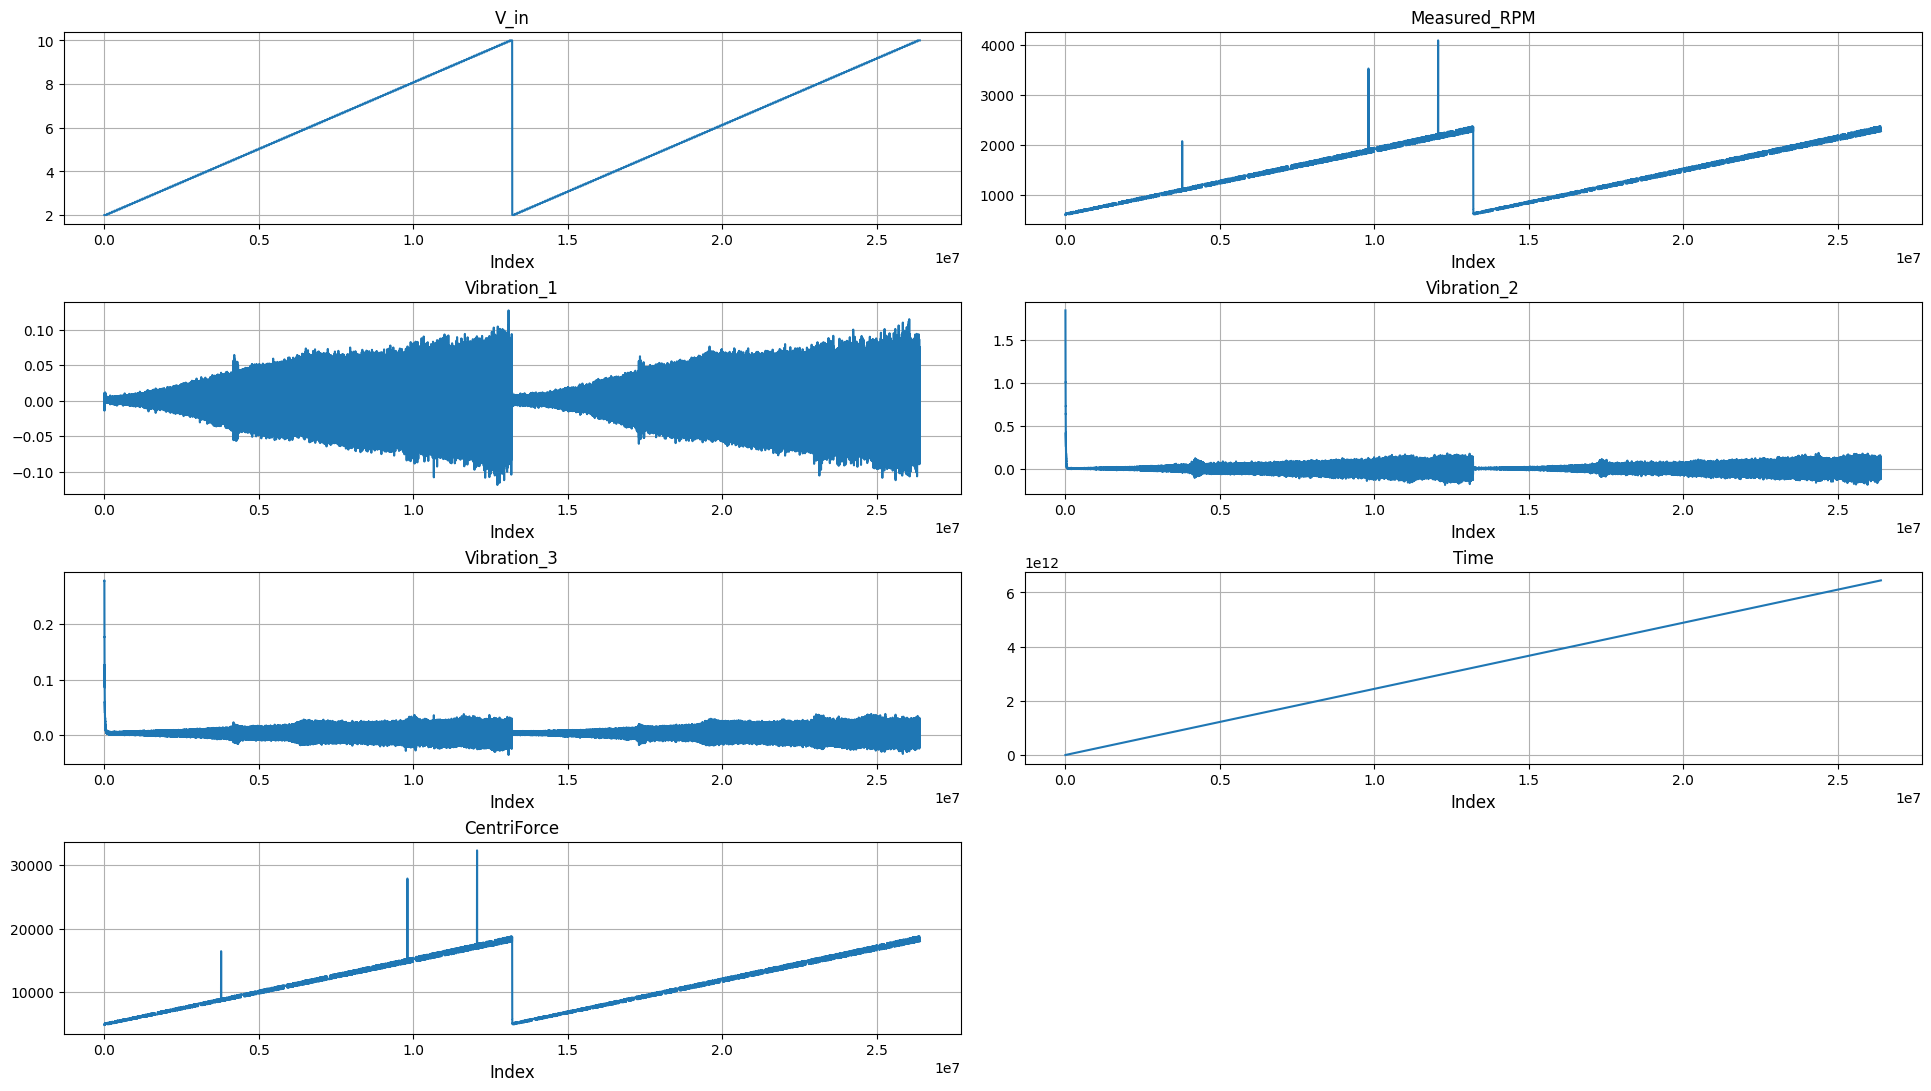

In [23]:
import math

def plot_columns_as_subplots(data_frame: pd.DataFrame, columns: list, dpi=100, legend_loc="upper right"):
    """
    Plots selected columns of a pandas DataFrame as subplots in a 2-column layout,
    optimized for high DPI values without visual distortion.
    
    Parameters:
    - data_frame: pd.DataFrame
        The DataFrame containing the data to plot.
    - columns: list
        List of column names to be plotted.
    - dpi: int (default=100)
        Dots per inch for the figure resolution.
    - legend_loc: str (default="upper right")
        Location of the legend in the plot.
        
    Returns:
    - None
    """
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError("data_frame must be a pandas DataFrame.")
    
    if not all(col in data_frame.columns for col in columns):
        raise ValueError("Some columns are not present in the DataFrame.")
    
    # Anzahl der Subplots
    n_plots = len(columns)
    
    # Subplots in zwei Spalten anordnen
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)
    
    # Berechne die Größe der Figur basierend auf 1920x1080 Pixeln
    figsize = (1920 / dpi, 1080 / dpi)
    scaling_factor = dpi / 100  # Skalierungsfaktor für hohe DPI-Werte
    
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=figsize, dpi=dpi, constrained_layout=True
    )
    
    # axes in eine flache Liste umwandeln, um Iteration zu erleichtern
    axes = axes.flatten()
    
    # Plotte jede Spalte
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.plot(data_frame[col], label=col, linewidth=1.5 * scaling_factor)
        ax.set_title(col, fontsize=12 * scaling_factor)
        #ax.legend(fontsize=10 * scaling_factor, loc=legend_loc)
        ax.grid(True)
    
    # Entferne ungenutzte Subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    # Gemeinsame Achsenbeschriftung
    for ax in axes: #[-n_cols:]:
        ax.set_xlabel("Index", fontsize=12 * scaling_factor)
    
    # Anzeige
    plt.show()


plot_columns_as_subplots(test.data, test.data.columns.values)

In [ ]:
print(test.data.index)

RangeIndex(start=12288, stop=26387906, step=1)


[607.52576]
607.52576
2048


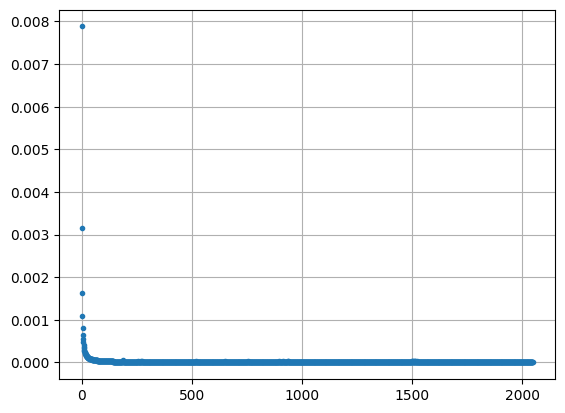

In [27]:
from statistics import fmean
n = 4095
dt = 1 / n
signal = test.data["Vibration_1"].iloc[0:n]
rpm = test.data["Measured_RPM"].iloc[0:n].unique()
print(rpm)
print(fmean(rpm))
y = np.fft.rfft(signal)
f = np.fft.rfftfreq(n=n,d=dt)
plt.plot(f, 1.0/n * np.abs(y), ".")

plt.grid()
print(len(y))
plt.show()

#### **Visualisierung der Daten**

In [7]:
display(training_data[3].describe())

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.638791e+07,2.638790e+07,2.638791e+07,2.638791e+07,2.638790e+07
mean,5.996809e+00,-3.577469e+04,1.110836e-03,2.465983e-03,3.448805e-03
std,2.326625e+00,2.989907e+06,4.001031e-02,7.958974e-02,3.795273e-02
min,0.000000e+00,-2.400000e+08,-1.187980e-01,-1.914287e-01,-3.666401e-02
25%,4.000000e+00,1.051479e+03,-1.876354e-03,-2.229214e-03,1.395941e-03
50%,6.000000e+00,1.479773e+03,6.973743e-04,6.723404e-04,2.921820e-03
75%,8.000000e+00,1.906608e+03,3.694296e-03,3.556013e-03,4.649162e-03
max,1.000000e+01,4.091723e+03,6.956823e+00,8.520829e+00,6.592745e+00


In [44]:
info_path = list(Path.cwd().rglob("meta_data.yaml"))[0]
with open(info_path, "r") as file:
    info = list(yaml.safe_load_all(file))[1]["0D"]
    print(info)

{'unbalance': 'none', 'mass': 0.0, 'mass_tolerance': 0.0, 'radius': 0.0, 'radius_tolerance': 0.0, 'voltage_start': 2.0, 'voltage_end': 10.05, 'voltage_step': 0.05}


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
0,0.0,2.861023e+01,0.000000,0.000000,0.000000
10000,0.0,-2.400000e+08,0.219203,2.531375,0.573618
20000,2.0,6.449152e+02,0.019007,0.733600,0.147095
30000,2.0,6.378314e+02,0.013081,0.232453,0.052155
40000,2.0,6.375044e+02,0.008260,0.079712,0.022458
...,...,...,...,...,...
26350000,10.0,2.278077e+03,0.054388,0.016685,-0.002849
26360000,10.0,2.376473e+03,0.021167,0.022061,0.007240
26370000,10.0,2.341121e+03,-0.007980,0.012766,0.009121
26380000,10.0,2.376473e+03,0.038943,-0.001593,-0.009680


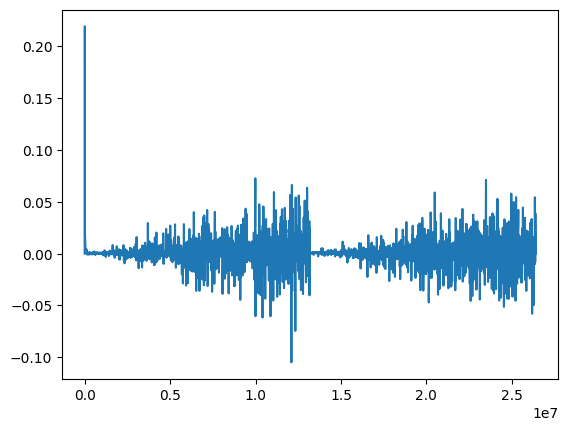

In [8]:
# ! WARNING: causes graphic card shutdown after ~80 minutes! 
#sns.pairplot(training_data[0])
#plt.show()
data_index = 4
vibration_index = 1
test = training_data[data_index].iloc[0::10000]
display(test)
# plt.plot(training_data[data_index][f"Vibration_{vibration_index}"].iloc[int(.01e7):])
plt.plot(test["Vibration_1"])
# plt.plot(training_data[3]["Vibration_2"])
# plt.plot(training_data[3]["Vibration_3"])
#training_data[3].hist(bins=15, figsize=(15,10))
#plt.tight_layout()
# sns.pairplot(test)
plt.show()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
40000,2.0,637.50442,0.008260,0.079712,0.022458
40001,2.0,637.50442,0.007141,0.078759,0.022954
40002,2.0,637.50442,0.007797,0.078187,0.022345
40003,2.0,637.50442,0.007539,0.078318,0.022300
40004,2.0,637.50442,0.007088,0.078512,0.021989


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
0,0.0,28.610235,0.0,0.0,0.0
1,0.0,28.610235,0.0,0.0,0.0
2,0.0,28.610235,0.0,0.0,0.0
3,0.0,28.610235,0.0,0.0,0.0
4,0.0,28.610235,0.0,0.0,0.0


C:\Users\lukas\AppData\Local\Temp\ipykernel_22400\2794299137.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lukas\AppData\Local\Temp\ipykernel_22400\2794299137.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\Studium\Desktop\KIM_Künstliche_Intelligenz_im_Maschinenbau\project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


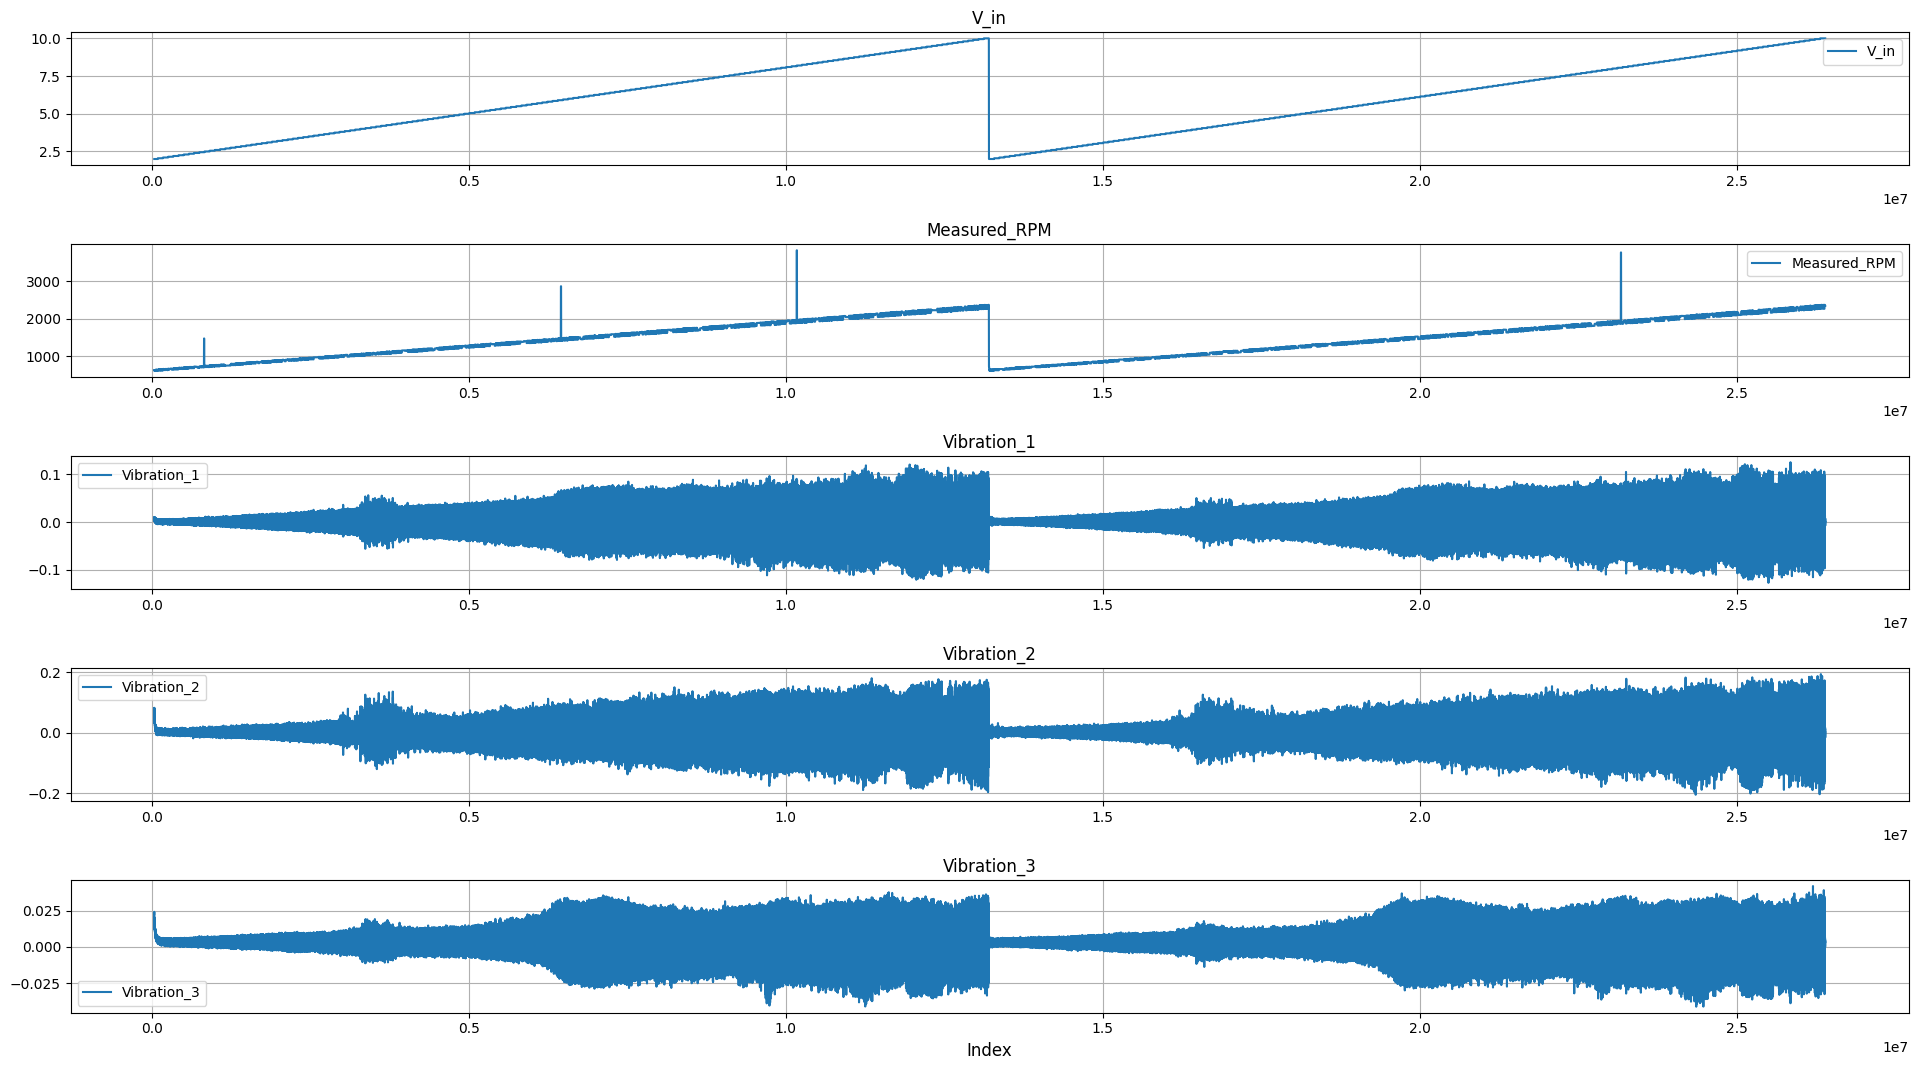

In [26]:
def plot_columns_as_subplots(data_frame: pd.DataFrame, columns: list, dpi=100):
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError("data_frame must be a pandas DataFrame.")
    
    if not all(col in data_frame.columns for col in columns):
        raise ValueError("Some columns are not present in the DataFrame.")
    
    n_plots = len(columns)
    
    figsize = (1920 / dpi, 1080 / dpi)
    
    _, axes = plt.subplots(
        n_plots, 1, figsize=figsize, dpi=dpi, constrained_layout=True
    )
    
    if n_plots == 1:
        axes = [axes]
    
    for ax, col in zip(axes, columns):
        ax.plot(data_frame[col], label=col)
        ax.set_title(col, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    
    axes[-1].set_xlabel("Index", fontsize=12)
    
    plt.tight_layout()
    
    plt.show()


with open("meta_data.yaml", "r") as file:
        columns = yaml.safe_load(file)["columns"]

data_index = 4
test = training_data[data_index].iloc[40000:]
display(test.head())
display(training_data[data_index].head())
plot_columns_as_subplots(test, columns=columns)

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07
mean,5.997206e+00,-3.576920e+04,1.139313e-03,2.412792e-03,3.749252e-03
std,2.326852e+00,2.989759e+06,4.087136e-02,8.043873e-02,3.956148e-02
min,0.000000e+00,-2.400000e+08,-1.271856e-01,-2.047277e-01,-4.108310e-02
25%,4.000000e+00,1.052290e+03,-3.775358e-03,-4.433393e-03,4.947185e-04
50%,6.000000e+00,1.477250e+03,6.437302e-04,6.008148e-04,3.159046e-03
75%,8.000000e+00,1.905881e+03,5.478859e-03,5.640984e-03,5.917549e-03
max,1.000000e+01,3.830562e+03,6.833680e+00,8.469567e+00,6.548744e+00


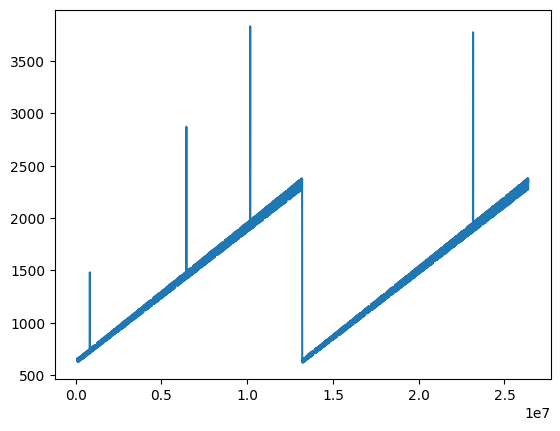

In [ ]:
data_index = 4
vibration_index = 1
display(training_data[data_index].describe())
plt.plot(training_data[data_index]["Measured_RPM"].iloc[int(.01e7):])
plt.show()

In [ ]:
def add_time(data_frame: pd.DataFrame) -> None:
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError("The object passed is no pandas DataFrame.")
    
    with open("meta_data.yaml", "r") as file:
        sample_rate = yaml.safe_load(file)["sample_rate"]

    data_frame["Time"] = pd.to_datetime(
        data_frame.index / sample_rate,
        unit="s")

def reset_data_frame(data_frame: pd.DataFrame) ->None:
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError("The object passed is no pandas DataFrame.")
    
    with open("meta_data.yaml", "r") as file:
        columns = yaml.safe_load(file)["columns"]

    data_frame.drop(
        labels=data_frame.columns.difference(columns),
        axis="columns",
        inplace=True
        )

add_time(training_data[1])

display(type(training_data[1]["Time"]))
#reset_data_frame(training_data[1])

pandas.core.series.Series

In [45]:
display(training_data[1].describe())

corr_matrix = training_data[1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

corr_matrix = training_data[1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()


NameError: name 'training_data' is not defined

In [ ]:
print(type(training_data[1]["Time"]))
def differentiate(y: np.array, x: np.array, di: int = 1, mode: str = "central"):
    valid_modes = ["forward", "backward", "central"]
    if mode not in valid_modes:
        raise AttributeError(f"Selected mode invalid! Please choose one of the follwing:\t{valid_modes}")
    
    dydx = np.zeros(y.shape, dtype=np.float64)

    if mode == valid_modes[0]:
        for i in range(start=0, stop=dydx-di):
            dydx[i] = (y[i+di] - y[i]) / (x[i+di] - x[i])
    elif mode == valid_modes[1]:
        for i in range(start=di, stop=dydx.size):
            dydx[i] = (y[i] - y[i-di]) / (x[i] - x[i-di])
    elif mode == valid_modes[2]:
        for i in range(di, dydx.size-di):
            dydx[i] = (y[i+di] - y[i-di]) / (x[i+di] - x[i-di])


    display(dydx)

display(type(training_data[1]["Time"]))

display(training_data[1]["Time"].seconds() + training_data[1]["Time"].microseconds() / 10^6)

differentiate(y=training_data[1]["Measured_RPM"].to_numpy(dtype=np.float64), x=training_data[1]["Time"].dt.total_seconds())

<class 'pandas.core.series.Series'>


pandas.core.series.Series

AttributeError: 'Series' object has no attribute 'seconds'